In [1]:
# Import packages
import plotly.express as px
import pandas as pd

# Read in the data
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])


def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x='Month', y=y, labels={'Month': 'Date'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Airline Passengers',
                      width=650, title_x=0.5, height=400)

    return fig.show()


# Plot the airline passenger data
plot_passenger_volumes(df=data, y='#Passengers')

In [2]:
# Import packages
from scipy.stats import boxcox

# Make the target stationary
data['Passengers_boxcox'], lam = boxcox(data['#Passengers'])
data["Passenger_stationary"] = data["Passengers_boxcox"].diff()
data.dropna(inplace=True)

# Plot the stationary airline passenger data
plot_passenger_volumes(df=data, y='Passenger_stationary')

## Modelling

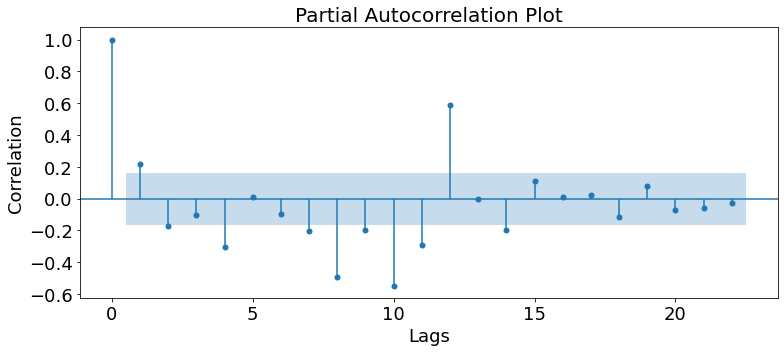

In [3]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Plot partial autocorrelation
plt.rc("figure", figsize=(11,5))
plot_pacf(data['Passenger_stationary'], method='ywm')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

In [4]:
# Import packages
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build AR model
selector = ar_select_order(train['Passenger_stationary'], 15)
model = AutoReg(train['Passenger_stationary'], lags=selector.ar_lags).fit()

c:\Users\heito\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\heito\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

c:\Users\heito\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\heito\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



## Results

When we apply the model, we apply it onto the transformed series. That said, once the model is fitted we have to reverse the trnasformation to get the results in the same scale we used to have.

In [5]:
# Import packages
from scipy.special import inv_boxcox
import plotly.graph_objects as go

# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Passengers_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')

c:\Users\heito\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

